<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

###  Feature Engineering, Regression, and Regularization

---

The application of machine learning to home pricing is a burgeoning field. Companies like OpenDoor are taking on the historically insular and unscientific real estate sales market by applying data science to better predict trends, detect patterns, and ultimately undercut the competition. 

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The housing data available in this project has around 80 different variables cataloguing a wide variety of attributes for real estate properties. The target variable of interest is the sales price.

What has the most impact on the sales price of a house? Is just using square footage and building age sufficient, or are there other less obvious factors at play? You'll get to investigate what's important using EDA and regularized regression models, and practice model evaluation and cross-validation.

---

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Load the `housing.csv` dataset

---

The csv is located in the `DSI-SF-4/datasets/housing_regression` folder in your repo. 

**There is a file describing the columns in the dataset in the `data_description.txt` file in the same folder that contains the information on what the variables represent.**


In [43]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [44]:
house_reg = pd.read_csv('../../datasets/housing_regression/housing.csv')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Examine the `SalePrice` variable

---

### 2.1 Plot the distribution of the `SalesPrice` variable and describe it with pandas

In [45]:
house_reg.shape

(1460, 81)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

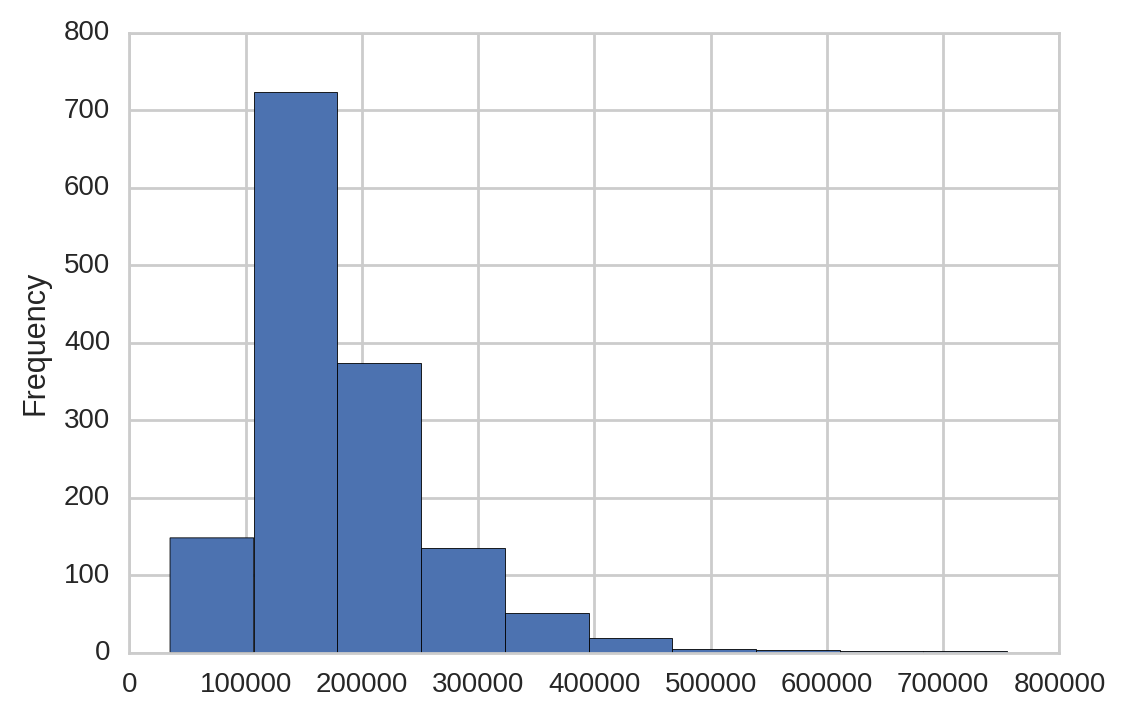

In [46]:
house_reg.SalePrice.plot(kind='hist')
house_reg.SalePrice.describe().T

### 2.2 Create a transformed version of the `SalesPrice` variable that makes it more normally distributed

Two common transformations to deal with long tails are taking the square root and taking the log of a variable. 

Plot the transformed variable.

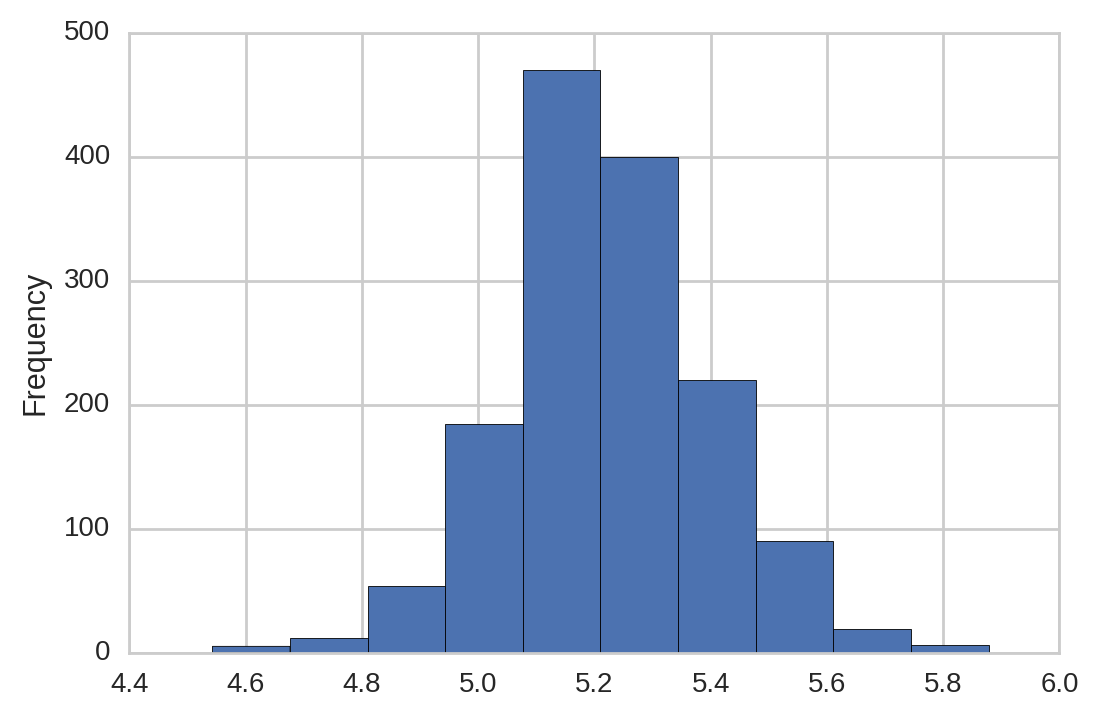

In [47]:
house_reg['logSalePrice'] = np.log10(house_reg['SalePrice'])
house_reg.logSalePrice.plot(kind='hist')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Correlations with sale price

---

### 3.1 Correlate the age of a house when sold with the sale price

How is the correlation different when using the original and transformed sale price?


In [48]:
house_reg['age_when_sold'] = house_reg['YrSold'] - house_reg['YearBuilt']
house_reg[['age_when_sold', 'SalePrice']].corr(), house_reg[['age_when_sold', 'logSalePrice']].corr()

# logSalePrice is slightly more correlated with 'age_when_sold' than SalePrice is

(               age_when_sold  SalePrice
 age_when_sold        1.00000   -0.52335
 SalePrice           -0.52335    1.00000,
                age_when_sold  logSalePrice
 age_when_sold        1.00000      -0.58729
 logSalePrice        -0.58729       1.00000)

### 3.2 Plot the age of the house at sale against the sale price variables

How does it differ between the original and transformed variables? What do the charts indicate about the relationship between the variables?

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd145ca6210>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1450e9f90>)

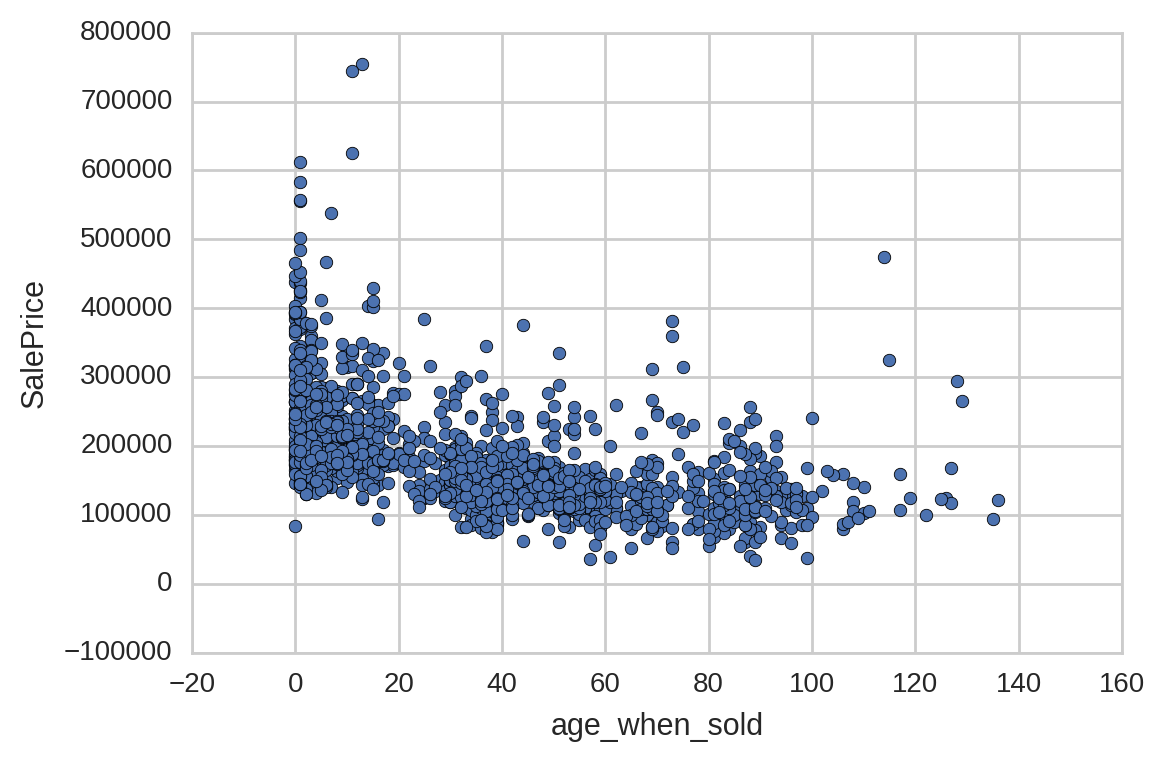

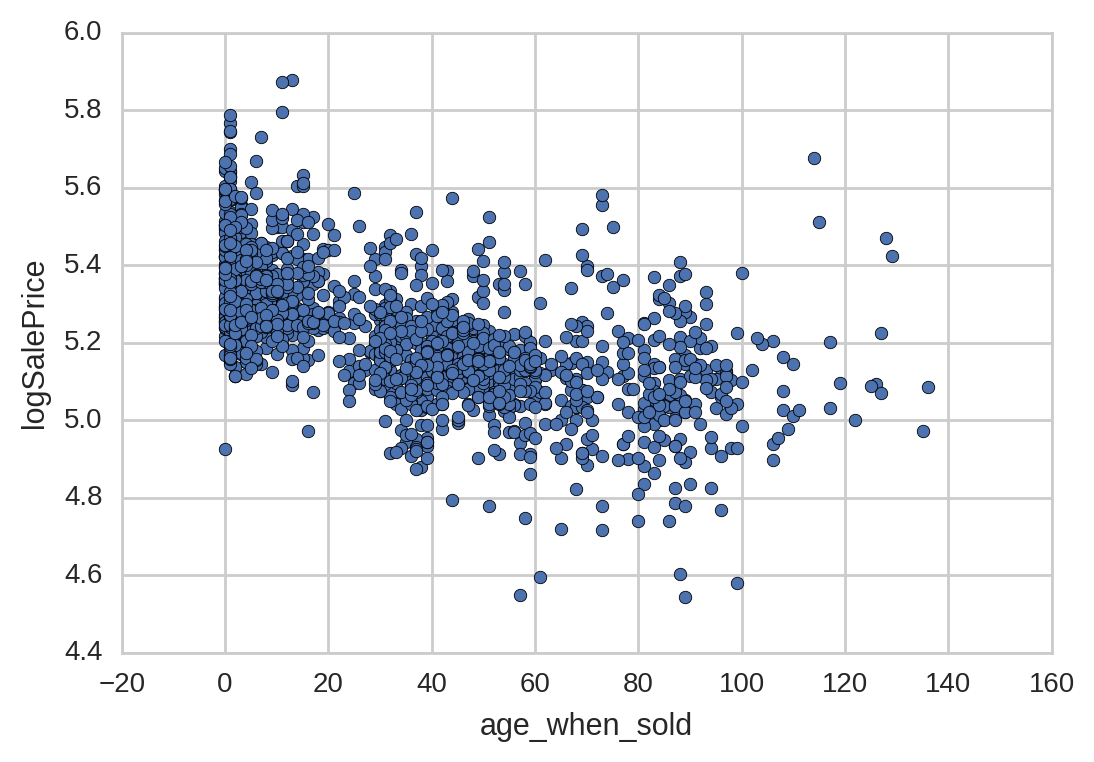

In [49]:
house_reg.plot(x='age_when_sold', y='SalePrice', kind='scatter'), house_reg.plot(x='age_when_sold', y='logSalePrice', kind='scatter')

### 3.3 Visually compare price to total livable square feet, `GrLivArea`

What is the relationship, if any?

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd145ef5950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd145df41d0>)

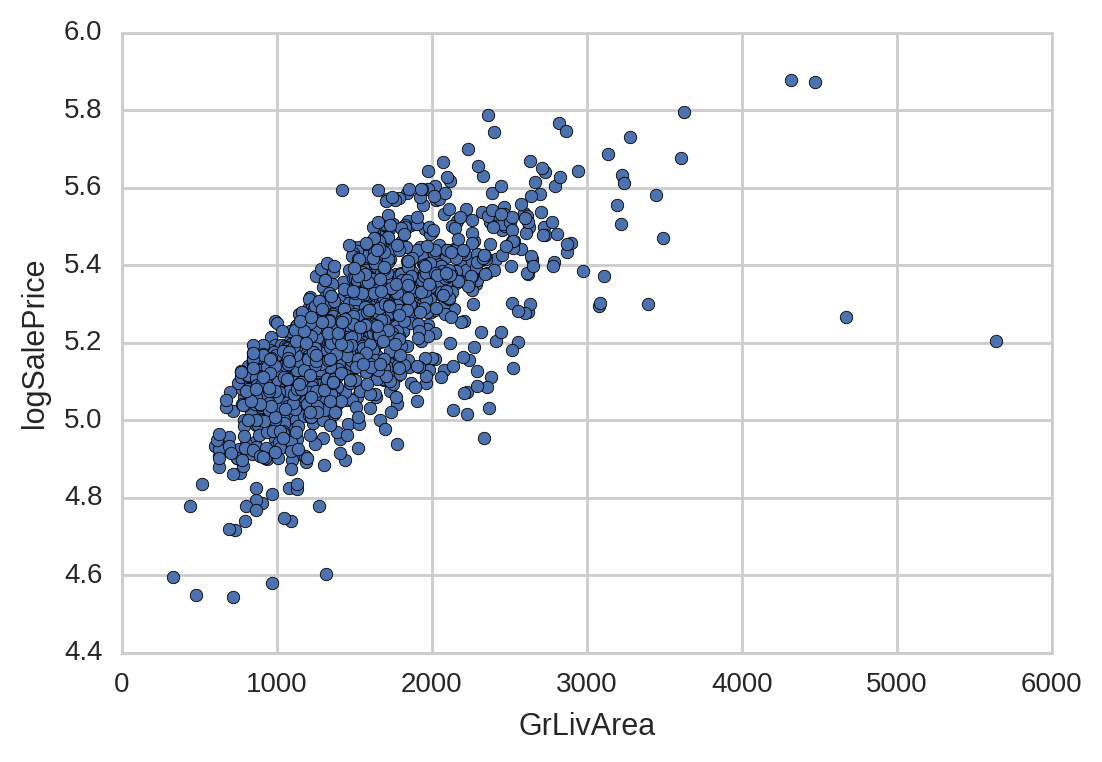

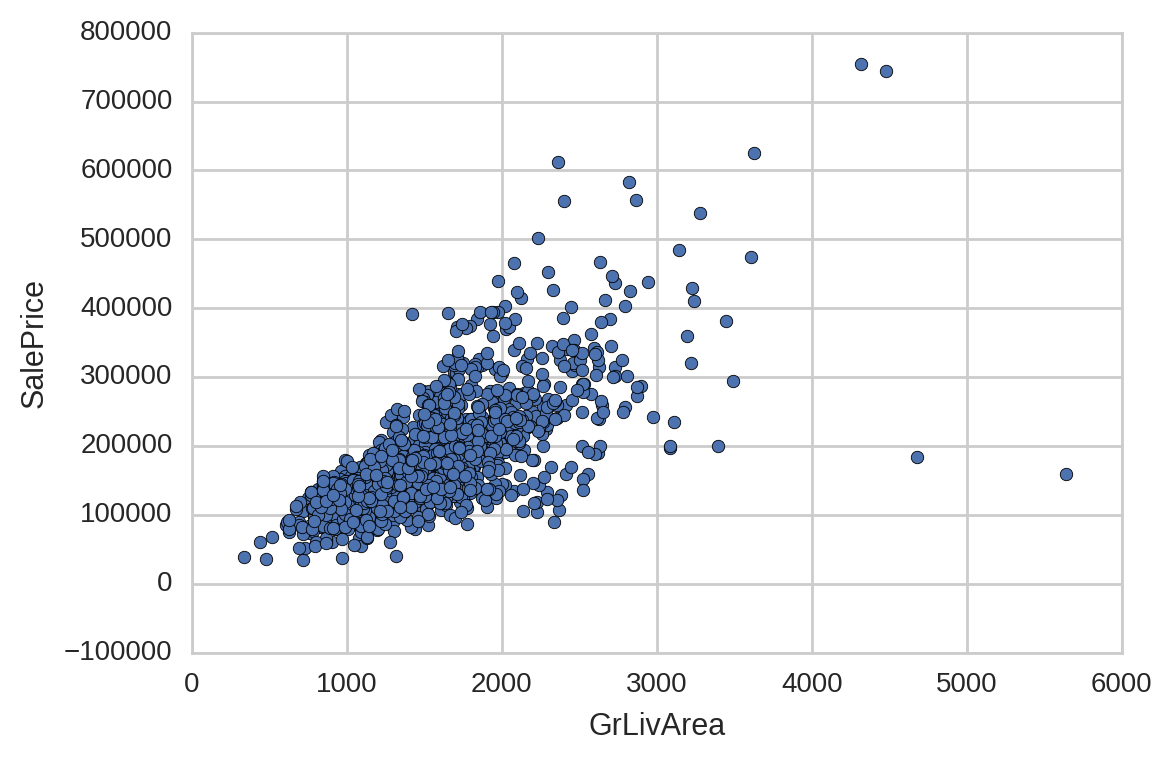

In [50]:
house_reg.plot(x='GrLivArea', y='logSalePrice', kind='scatter'), house_reg.plot(x='GrLivArea', y='SalePrice', kind='scatter')

### 3.4 Plot and describe the relationship between two continuous variables of your choice in the data

Why did you choose those variables? What is the relationship that the chart sbows, if any?

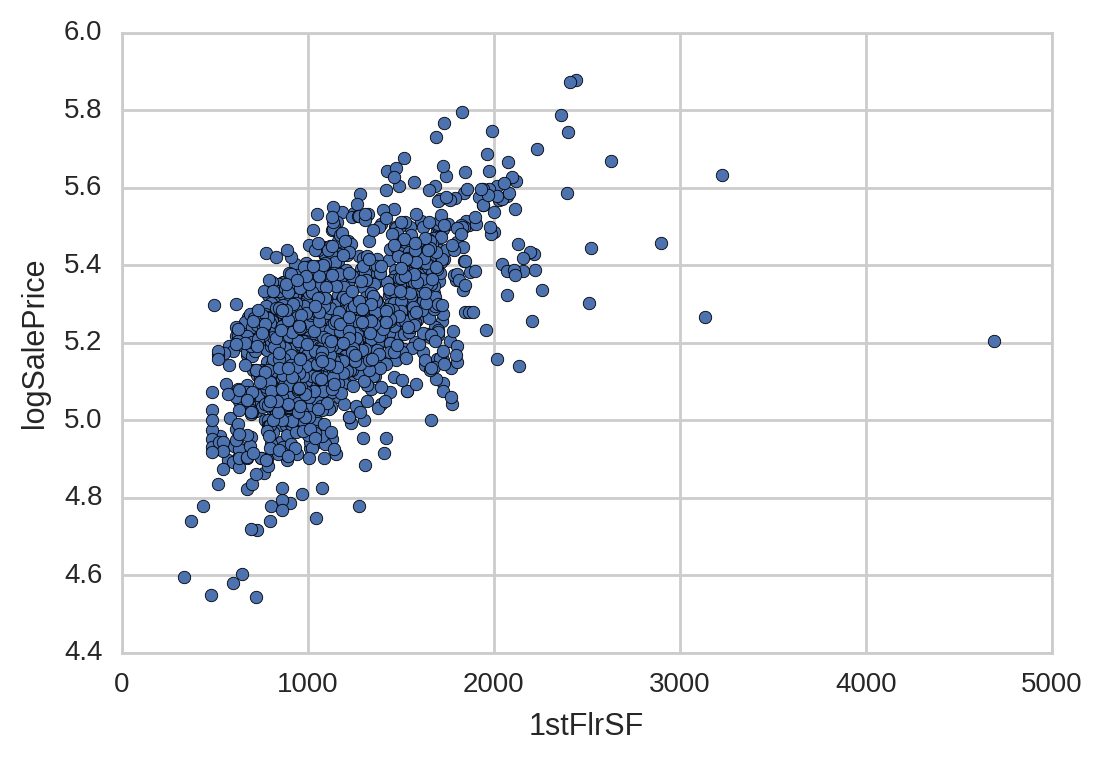

In [51]:
# I chose logSalePrice since it is a more normal version of the most interesting variable in the dataset (Sale
# Price) and 1stFlrSF because I thought this variable would be one of the best indicators for Sale Price among the 
# variables in the dataset.

house_reg.plot(x='1stFlrSF', y='logSalePrice', kind='scatter')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Data transformation and quality assessment

---

**Note: from this point onward, you can use your transformed price variable or the original price variable. Up to you. It will change the interpretation of the coefficients in your model.**

### 4.1 Restrict the data 

Only keep houses that are residential (remove the commercial code buildings).

In [52]:
house_reg.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,logSalePrice,age_when_sold
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,5.319106,5
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,5.258877,31
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,5.349278,7
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,5.146128,91
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,5.397940,8


In [53]:
house_reg.shape

(1460, 83)

In [63]:
residential_houses = house_reg.ix[~(house_reg['MSZoning'].isin(['C'])), :]
residential_houses.shape

(1460, 83)

### 4.2 Handle null values in the dataset

Many of the variables contain null values. In many of these cases the null value is actually representative of a category that is a level of a categorical variable.

Eliminate the null values from your dataset, explaining your rationale for each variable. You have options for null values:

- Replace the null values (impute).
- Drop the observation.
- Drop the variable. 

### 4.3 Remove any variables you think are not viable to use as predictors of price.

This can be a subjective process. A common criterion is to remove variables that have little to no variance. This would be, for example, a  variable where nearly all observations were in a single category or had a single value. 

For each variable you remove (if any), explain your rationale for why.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Plot a correlation matrix between the continuous variables

---

**Some columns in the DataFrame are numeric type, but that doesn't necessarily mean that they are continuous. Sometimes numeric values are used to represent the levels of a categorical variable.**

To plot a correlation matrix, it is popular to represent the correlation values using hue with a "heatmap". Look up how to plot a heatmap of a correlation matrix in python and show it below. Make sure that the variable labels are clear on the axes.

Describe anything interesting or notable you observe from the correlation matrix.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Make boxplots of categorical variables against the sale price

---

You don't have to plot all of them unless you want to. Make at least 8 boxplots looking at the distribution of sale price across levels of categorical variables in your dataset. This can be whichever categorical variables interest you the most.

Write up a few findings on the relationship between sales price and the categorical variables you chose to plot. Anything surprising?

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7. Univariate regression predicting price with statsmodels

---

### 7.1 Build a linear regression with statsmodels predicting sales price from total living area sq ft.

Print the results of the regression.


### 7.2 Explain the regression results

What do each of these things represent/mean?

1. The intercept coefficient.
2. The coefficient on GrLivArea.
3. The R-squared value.
4. The p-value for coefficients (P>|t|)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 8. Multivariate regression predicting price with sklearn

---

### 8.1 Build an sklearn linear regression predicting sale price 

Use all of your continuous measures as predictors (no categorical yet).

### 8.2 Calculate the $R^2$ of your model.

### 8.3 Plot the residuals against the true values.

### 8.4 Plot a histogram of the residuals.

### 8.5 Make a plot to show the strength of the different coefficients.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 9. Create a predictor matrix using all viable predictors available to you

---

You will need to dummy code the categorical variables. This is done most easily using patsy by constructing a formula string to make the matrix, but can be done with sklearn functions or manually as well. 

Recall that the `C(variable)` syntax in patsy formulas will take the column named `'variable'` and make it into dummy coded columns. You may also need to rename columns, patsy has trouble with column names that start with numbers.

Lastly, remember that you may need to convert your target `y` from a matrix to a vector (patsy outputs it as 2D rather than 1D, which skearn may have trouble with.)

### 9.2 Fit a linear regression using all of the predictors and score it.

### 9.3 Explain why this model and associated $R^2$ score may not be as "good" as they seem.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 10. Cross-validate the model

---

Use 20 folds and calculate the average $R^2$ of your model that has all of the predictors in it.

### 10.2 What does the cross-validated average $R^2$ tell you?

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 10.3 When can you have a negative $R^2$ score? Explain what it means.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 11. Construct a Lasso regression and find the optimal regularization strength

---

Now you'll fit a Lasso regression using again the full predictor matrix. 

### 11.1 Using either `LassoCV` or `GridSearchCV` with `Lasso`, find the optimal regularization strength.

You are finding the best `alpha` to use with this data. For `LassoCV` you can use the `n_alphas` parameter to specify how many possible alphas you want the model to search over. With `GridSearchCV` you will have to give it a vector of the alphas you want to try.

Note that in both cases you will need to specify the number of cross-validation folds `cv`. 10 is generally a good number of folds. 

**Remember that you must standardize your predictor matrix when using regularization!**

### 11.2 Construct a `Lasso` model with the optimal `alpha` and cross-validate the $R^2$.

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 11.3 Explain the effect of the Lasso regularization and why it can be useful.

### 11.4 Print out the variables with non-zero Lasso coefficients (with the coefficient).

How many variables remain? 

Tell a (brief) story about what is important for estimating price based on the variables and their coefficients. Just pick out the things most interesting to you.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 12. Construct a Ridge regression and find the optimal regularization strength

---

### 12.1 Create a predictor matrix of only variables related to sq. ft.

**Remember that you must standardize your predictor matrix before using Ridge regularization.**

### 12.2 Plot a correlation matrix of your predictors. Why might Ridge be useful here?

### 12.3 Find the optimal Ridge `alpha` using either `RidgeCV` or a combination of `GridSearchCV` and `Ridge`.



### 12.4 Compare the cross-validated $R^2$ score for a standard Linear Regression and your Ridge regression

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 13. Explain the difference between Ridge and Lasso regularization

---

- When are good scenarios to use each? What problems do they address?
- Why do they have the effects they do on coefficients?
- What is their effect on bias and variance?

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 14. Gridsearch an optimal `ElasticNet` regression.

---

On the full predictor matrix, search for the optimal hyperparameters for an Elastic Net regression. Remember that the Elastic net is a mixture of the Ridge and Lasso, and has both an `alpha` parameter to regularize as well as an `l1_ratio`, which is the balance of Lasso vs. Ridge.

How does the ElasticNet compare to the Lasso on the dataset? What does the `l1_ratio` tell you about the balance of Ridge vs. Lasso in your model?

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 15. Further fine-tune the model to predict price

---

Your goal is to create the model with the best predictive power.

You can use as much feature engineering and transformation of variables that you want, but please limit yourself to using the regression models we have covered in class thus far. When we cover models like Random Forests and Gradient Boosted Trees we will return to this dataset and see how they compare to the regression models.

For those that tackle this problem, you will have a chance to show what you did and compare to what your other classmates came up with during class (if you want). **Feel free to collaborate with your classmates on improving the model!**